This notebook focuses on analysing the Seattle AirBnB dataset available from [Kaggle](https://www.kaggle.com/airbnb/seattle/data). This notebook was done as a project for the Data Scientist Nanodegree program on Udacity.

# Package import ad paths setup

!pip install missingno

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import missingno
import seaborn as sns
from functools import reduce

In [2]:
%matplotlib inline

In [3]:
DATA_FOLDER = Path('../data')

In [4]:
!ls $DATA_FOLDER

calendar.csv
listings.csv
reviews.csv


In [5]:
calendar = pd.read_csv(DATA_FOLDER / 'calendar.csv')
listings = pd.read_csv(DATA_FOLDER / 'listings.csv')
reviews = pd.read_csv(DATA_FOLDER / 'reviews.csv')

# Data quality

In this first section we will look into the quality of the data. Specifically we will look at missing values in the data. I like to use the package [missingno](https://github.com/ResidentMario/missingno), which gives a good overview of columns and where there are missing values.

## Calendar data

In [6]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [7]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


From the info above, we have some columns that need cleaning and type conversion. The date column needs to be converted to a datetime type and the price column needs to be cleaned and converted into a float type.

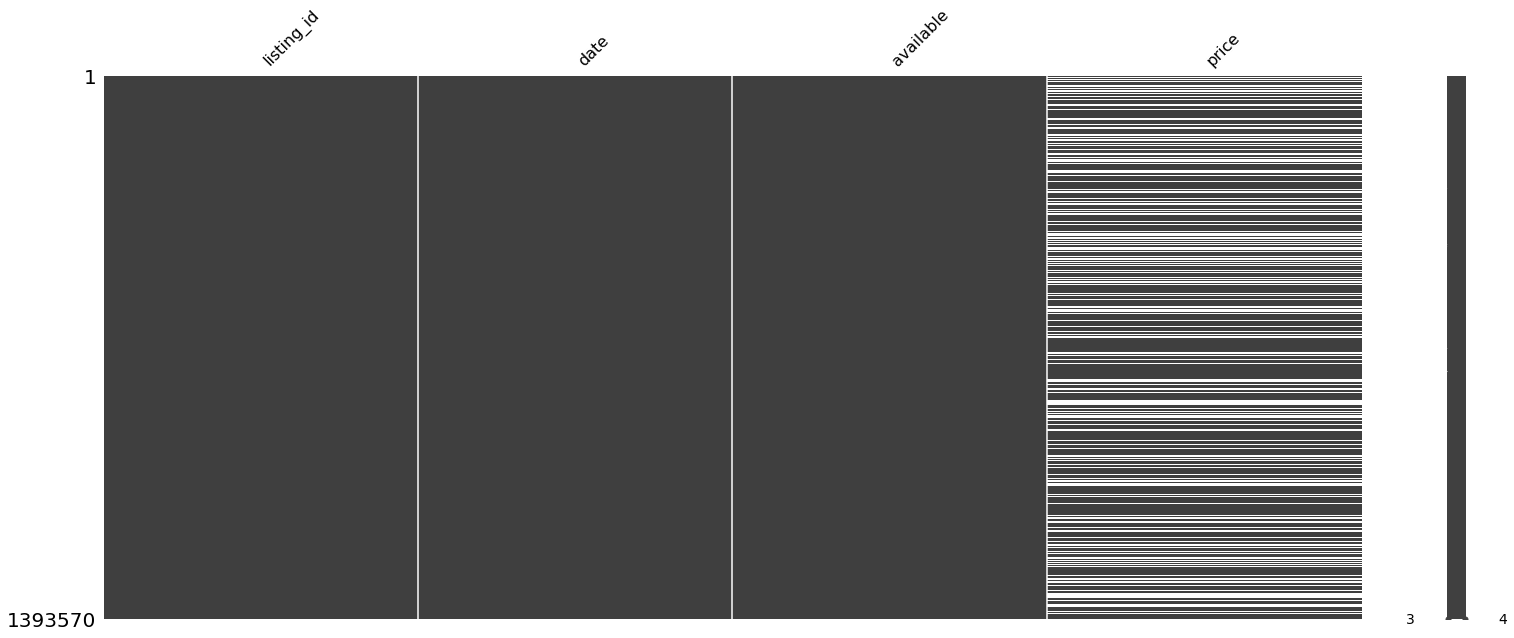

In [8]:
missingno.matrix(calendar);

This data shows what prices listings have had at a given time. Also it shows if the listing has been rented out or not.

Apparent from above is that the price column often has null values. Seing as the data lists prices and availability given a certain date, it is possible that this is a natural thing, since listings will be shown without prices, whenever they are rented out to visitors. We can investigate this by filtering all rows where `available == 'f'` and counting number of unique values

In [9]:
calendar[calendar['available'] == 'f']['price'].value_counts()

Series([], Name: price, dtype: int64)

Indeed for all rows where the listing is not available, price will be a NaN. We can also investigate if there are any rows with available listings where the price is NaN

In [10]:
calendar_nans = calendar[calendar.isna().any(axis=1)]

In [11]:
len(calendar_nans[calendar_nans['available'] == 't'])

0

This shows that the data is clean and we have a price for every row where a listing is available.

In [12]:
print(f'Number of rows in calendar data: {len(calendar)}')

Number of rows in calendar data: 1393570


### Cleaning

In [13]:
def clean_calendar(calendar):
    calendar_clean = calendar.copy()
    
    # Converting the date to a pandas datetime type
    calendar_clean['date'] = pd.to_datetime(calendar_clean['date'])
    
    # Converting price to a float value
    calendar_clean['cleaned_price'] = calendar_clean['price'].str.replace('[$,]','').astype('float')
    
    return calendar_clean

In [14]:
calendar_clean = clean_calendar(calendar)

## Listings data

In [15]:
# Allow printing of more rows, so we can see content of all columns in listings dataframe.
pd.options.display.max_rows = len(listings.columns)

In [16]:
listings.sample(10).T

,2799,1732,3776,1641,2025,2036,1598,1500,30,2210
id,458186,5252543,282934,8342429,9236814,7881802,1583047,4009508,2481869,6249164
listing_url,https://www.airbnb.com/rooms/458186,https://www.airbnb.com/rooms/5252543,https://www.airbnb.com/rooms/282934,https://www.airbnb.com/rooms/8342429,https://www.airbnb.com/rooms/9236814,https://www.airbnb.com/rooms/7881802,https://www.airbnb.com/rooms/1583047,https://www.airbnb.com/rooms/4009508,https://www.airbnb.com/rooms/2481869,https://www.airbnb.com/rooms/6249164
scrape_id,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432,20160104002432
last_scraped,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04,2016-01-04
name,The Tree Room with King-Sized Bed,Quiet room near bus line + ferry,Seattle Sojourn - Fremont Guest Apt,Cute Neighborhood/Downtown Studio,Greenwood Bungalow,4BD/3BA Cottage House in Greenwood,Charming First/Cap Hill 1 Bedroom,99 Lux Pike's Market 2BD,Airy + Bright Queen Anne Cottage,Single in Colorful Seattle Home
summary,NaN,Private day-lit basement bedroom with your own...,"Spacious, modern one-bedroom guest apartment i...",An extremely convenient neighborhood/downtown ...,Fantastic neighborhood in Seattle! Close to gr...,"This is a cottage-like four bedroom, three bat...",Steps away from the Pike/Pine corridor and a s...,Amazing 2 Bedroom apartment located in the hea...,Enjoy your own 1 BR cottage atop Queen Anne hi...,"Comfy room w. 6'6"" x 3' bed, adjacent bathroom..."
space,Extremely clean and comfortable bedroom with a...,"In the spring time, you wake to birds chirping...",The apartment is located in the lower level (d...,10 minute walk to Pike Place Market District,Cute and cozy place in a wonderful and fun nei...,"The Space This is a cottage-like four bedroom,...",GREAT LOCATION The apartment is located in qu...,"With a near 100% Walk-Score, this 2BD apartmen...","Beautiful carriage house in an extremely safe,...",European charm in an American 1950's bungalow ...
description,Extremely clean and comfortable bedroom with a...,Private day-lit basement bedroom with your own...,"Spacious, modern one-bedroom guest apartment i...",An extremely convenient neighborhood/downtown ...,Fantastic neighborhood in Seattle! Close to gr...,"This is a cottage-like four bedroom, three bat...",Steps away from the Pike/Pine corridor and a s...,Amazing 2 Bedroom apartment located in the hea...,Enjoy your own 1 BR cottage atop Queen Anne hi...,"Comfy room w. 6'6"" x 3' bed, adjacent bathroom..."
experiences_offered,none,none,none,none,none,none,none,none,none,none
neighborhood_overview,NaN,This is a quiet neighborhood that has quick ac...,Fremont is a vibrant neighborhood about four m...,"I love that I can step out into the street, lo...","With yoga studios, day spas, hair salons, dent...","Our neighborhood has endless numbers of shops,...",NaN,Can't get a reservation for your desired dates...,"Queen Anne is a wonderful, truly functional vi...",Kubota Garden is a 5-10 minute walk from our h...


In [17]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

A few columns need to be cleaned and converted to right type.

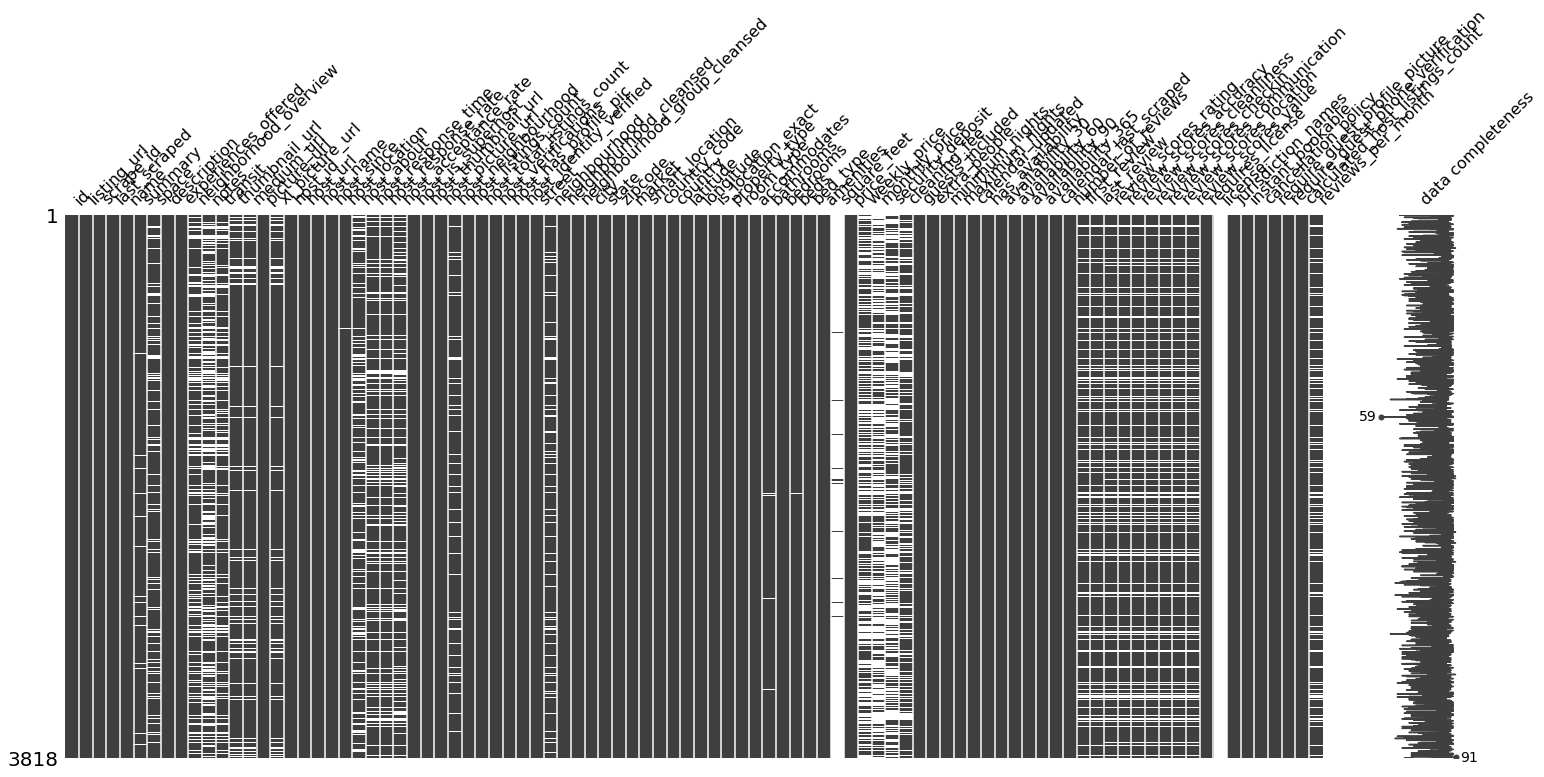

In [18]:
missingno.matrix(listings, labels=True);

This data describes each of the listings on AirBnB. There are a total of 91 columns and a lot of them have missing values at various places. 

The row with the minium missing values still has 59 values missing, and the row with the maximum values missing has 91 values missing. 

There are good reasons for listing data to have missing values since listings are of various types, also the owner might not have completed the many ways in which there is to describe the listing.

In [19]:
print(f'Number of rows in listings: {len(listings)}')

Number of rows in listings: 3818


### Cleaning

In [20]:
def clean_listings(listings):
    listings_clean = listings.copy()

    # Converting percentage strings into floats
    listings_clean['host_response_rate'] = listings_clean['host_response_rate'].str.replace('%','').astype('float')
    listings_clean['host_acceptance_rate'] = listings_clean['host_acceptance_rate'].str.replace('%','').astype('float')
    
    # Converting price to a float value
    listings_clean['price'] = listings_clean['price'].str.replace('[$,]','').astype('float')
    listings_clean['weekly_price'] = listings_clean['weekly_price'].str.replace('[$,]','').astype('float')
    listings_clean['monthly_price'] = listings_clean['monthly_price'].str.replace('[$,]','').astype('float')
    listings_clean['security_deposit'] = listings_clean['security_deposit'].str.replace('[$,]','').astype('float')
    listings_clean['cleaning_fee'] = listings_clean['cleaning_fee'].str.replace('[$,]','').astype('float')
    listings_clean['extra_people'] = listings_clean['extra_people'].str.replace('[$,]','').astype('float')
    
    # Converting the date to a pandas datetime type
    listings_clean['last_scraped'] = pd.to_datetime(listings_clean['last_scraped'])
    listings_clean['host_since'] = pd.to_datetime(listings_clean['host_since'])
    listings_clean['calendar_last_scraped'] = pd.to_datetime(listings_clean['calendar_last_scraped'])
    listings_clean['first_review'] = pd.to_datetime(listings_clean['first_review'])
    listings_clean['last_review'] = pd.to_datetime(listings_clean['last_review'])
    
    return listings_clean

In [21]:
listings_clean = clean_listings(listings)

## Reviews

In [22]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


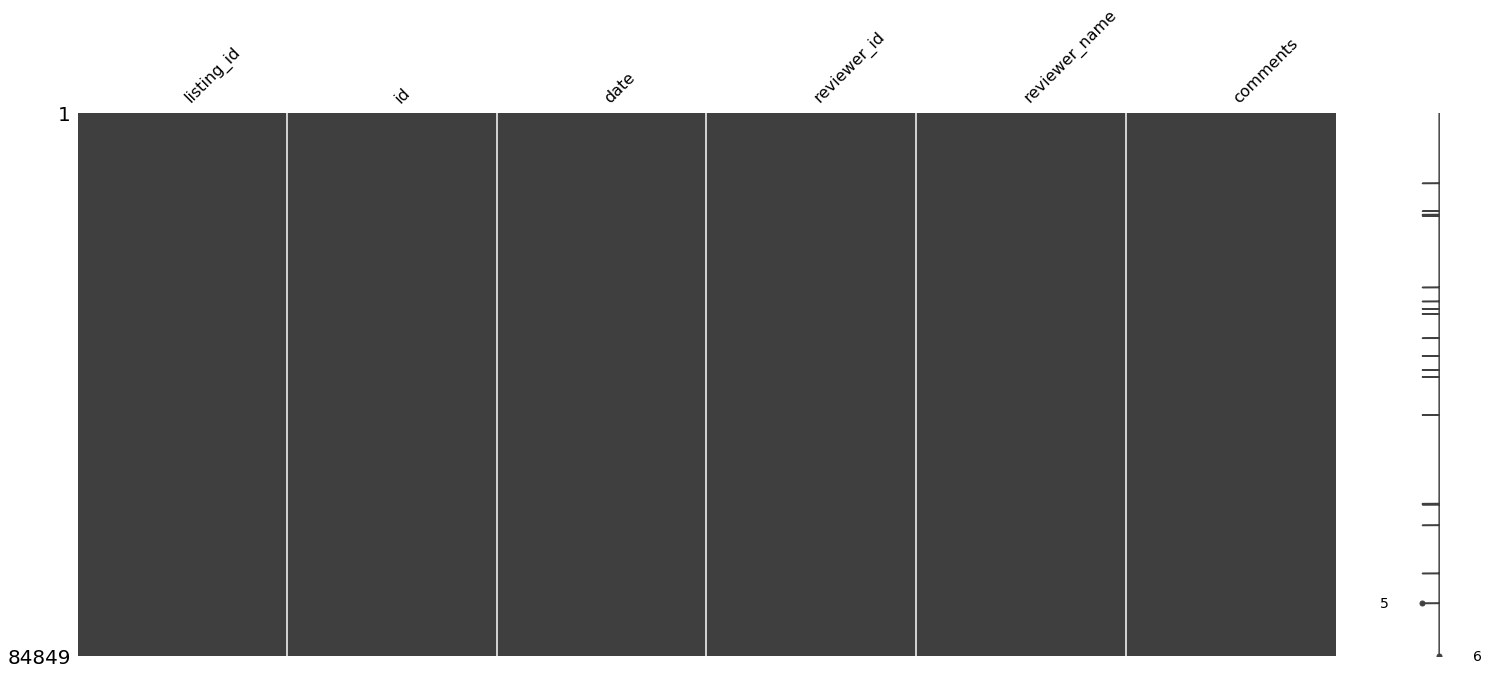

In [23]:
missingno.matrix(reviews)

This data shows the visitors reviews in text for a given listing, at a given date. Remarkably there are very few missing values.

In [24]:
print(f'Number of rows in reviews: {len(reviews)}')

Number of rows in reviews: 84849


# Business Understanding

Questions to answer with the data
- What is the yearly price trend?
- What are the top 10 neighborhoods and low 10 neighborhoods when it comes to price?
- Are there any property types that demand a higher price than others?
- How many consecutive days are properties usually rented out for?

# Q1: What is the yearly price trend

In [25]:
calendar_stats = calendar_clean[calendar_clean['available'] == 't'].groupby(['date']).agg({'cleaned_price':{'min','max','std','mean'}})
calendar_year = calendar_stats['2016-01-01':'2016-12-31']
calendar_month = calendar_stats.resample('M').mean()
calendar_month['month_names'] = calendar_month.index.strftime('%b')

Mean price: $137.66


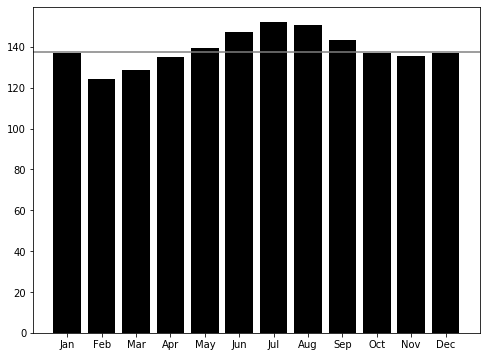

In [26]:
fig,ax = plt.subplots(figsize=(8,6))
ax.bar(calendar_month['month_names'], calendar_month['cleaned_price']['mean'], color='k')
price_mean = calendar_month['cleaned_price']['mean'].mean()
ax.axhline(calendar_month['cleaned_price']['mean'].mean(), c='gray')
print(f'Mean price: ${round(price_mean,2)}')
ax.grid(False)
ax.set_ylim(0,None);

From above the average price doesn't vary much over the year.

# Q2: What are the top 10 neighborhoods and low 10 neighborhoods when it comes to price?

In [27]:
neighbourhood_price = listings_clean[['id', 'neighbourhood_cleansed']].merge(calendar_clean, left_on='id', right_on='listing_id')

In [28]:
neighbourhood_pivot = neighbourhood_price.pivot(columns='neighbourhood_cleansed', values='cleaned_price')
neighbourhood_sort_index = neighbourhood_pivot.mean().sort_values(ascending=False).index

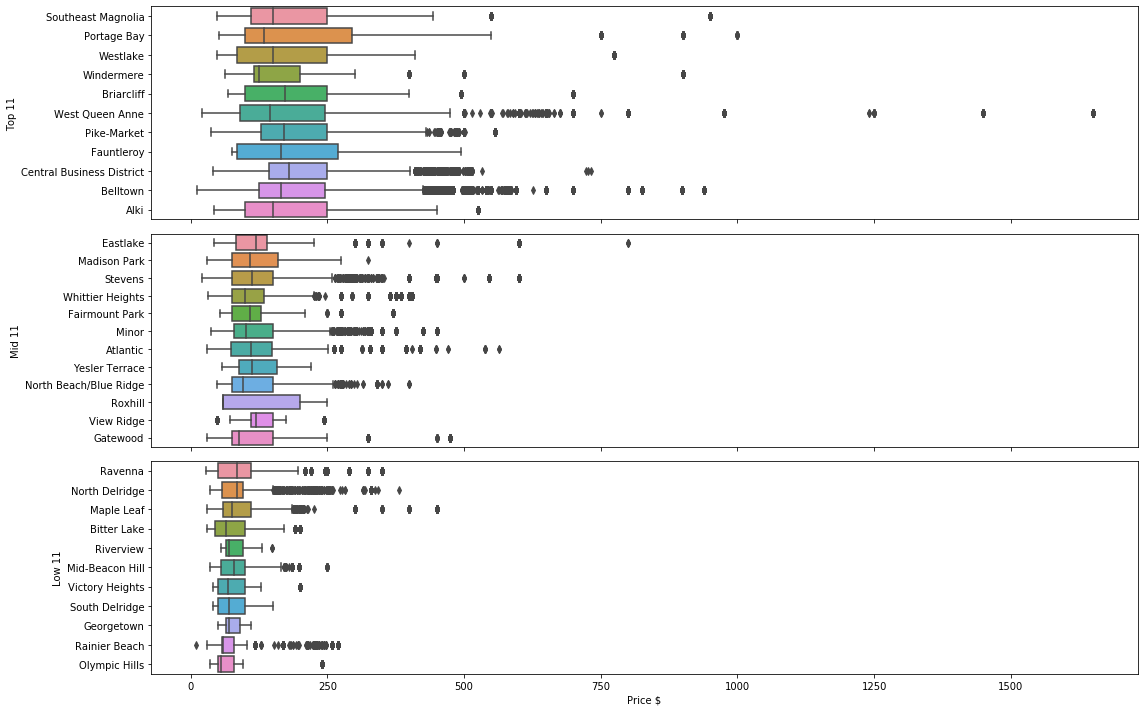

In [29]:
fig,ax = plt.subplots(3,1, figsize=(16,10), sharex=True)

sns.boxplot(data=neighbourhood_pivot[neighbourhood_sort_index[:11]], orient='h', ax=ax[0])
ax[0].set_ylabel('Top 11')

midpoint = len(neighbourhood_sort_index)/2
sns.boxplot(data=neighbourhood_pivot[neighbourhood_sort_index[round(midpoint-5):round(midpoint+6)]], orient='h', ax=ax[1])
ax[1].set_ylabel('Mid 11')

sns.boxplot(data=neighbourhood_pivot[neighbourhood_sort_index[-11:]], orient='h', ax=ax[2])
ax[2].set_ylabel('Low 11')
ax[2].set_xlabel('Price $')

fig.set_tight_layout(True);

# Q3: Property types vs price

In [30]:
room_type_price = listings_clean[['id', 'property_type']].merge(calendar_clean, left_on='id', right_on='listing_id')
room_type_price_pivot = room_type_price.pivot(columns='property_type', values='cleaned_price')

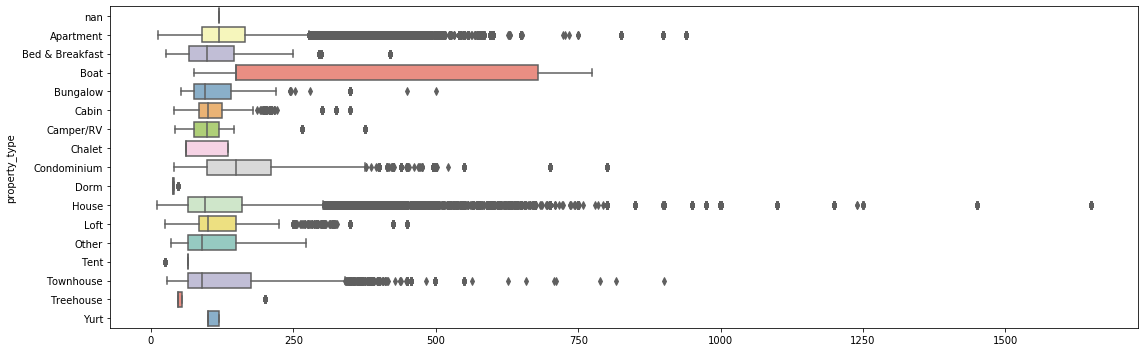

In [31]:
fig,ax = plt.subplots(figsize=(16,5))
sns.boxplot(data=room_type_price_pivot, orient='h', ax=ax, palette='Set3')
fig.set_tight_layout(True);

## Q4: Yearly availability trend

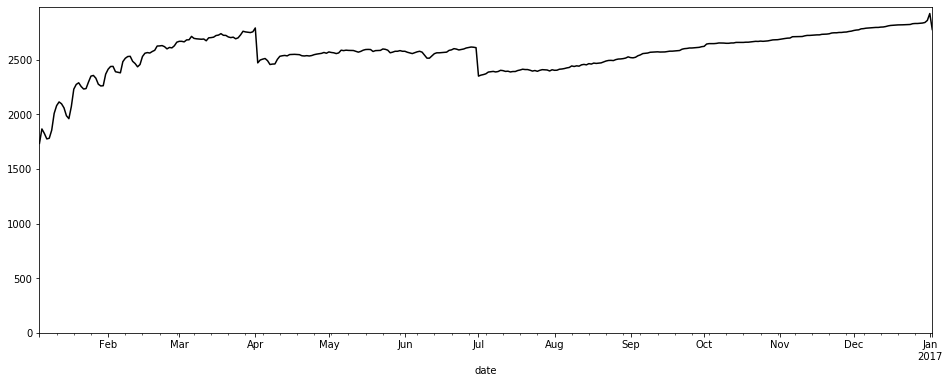

In [32]:
fig,ax = plt.subplots(figsize=(16,6))
calendar_clean[calendar_clean['available'] == 't'].groupby('date').size().plot(ax=ax, c='k')
ax.set_ylim(0,None);

The plot above shows the number of available listings for any given day of the year. Either there are some issues with the data or there are some very consistent trends. The sharp jumps at April and July signify that a lot of listings were either reserved or taken offline. 

## Q5: Consecutive rental days

In [33]:
calendar_pivot = calendar_clean.pivot(index='date', columns='listing_id', values='available')

consec_days = []
for col in calendar_pivot.columns:
    dat = calendar_pivot[col].reset_index()
    dat['grp'] = (dat[col] != dat[col].shift(1)).cumsum()
    dat = dat.groupby([col,'grp']).size().reset_index(name='consecutive_days')
    dat.columns = ['availability', 'group', 'consecutive_days']
    consec_days.append(dat)

res = reduce(lambda a,b : a.append(b), consec_days)

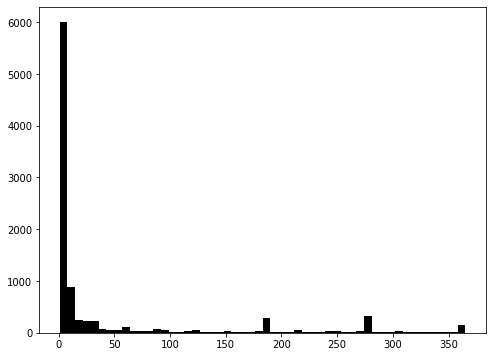

In [34]:
fig,ax = plt.subplots(figsize=(8,6))
consecutive_rented_days = res[res['availability'] == 'f']['consecutive_days']
bins = ax.hist(consecutive_rented_days, bins=52, color='k')
ax.set_yscale('linear');

- Caveat, might not be distinct customers (neck to neck bookings)
- Might not show longer than a year bookings also, since we only look at data for a year (not so critical)


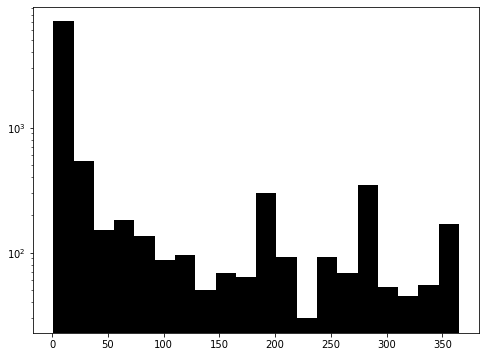

In [221]:
fig,ax = plt.subplots(figsize=(8,6))
consecutive_rented_days = res[res['availability'] == 'f']['consecutive_days']
ax.hist(consecutive_rented_days, bins=20, color='k')
ax.set_yscale('log')

## Are there any property types that show a norm of amount of consecutive rented days

In [36]:
res

,availability,group,consecutive_days
0,f,1,56
1,t,2,309
0,t,1,365
0,f,1,7
1,f,3,3
...,...,...,...
1,t,2,361
0,f,1,365
0,t,1,365
0,f,1,7


In [37]:
calendar_pivot = calendar_clean.pivot(index='date', columns='listing_id', values='available')

consec_days = []
for col in calendar_pivot.columns:
    dat = calendar_pivot[col].reset_index()
    dat['grp'] = (dat[col] != dat[col].shift(1)).cumsum()
    dat = dat.groupby([col,'grp']).size().reset_index(name='consecutive_days')
    dat.columns = ['availability', 'group', 'consecutive_days']
    dat['listing_id'] = col
    consec_days.append(dat)

res = reduce(lambda a,b : a.append(b), consec_days)

In [38]:
res.head()

,availability,group,consecutive_days,listing_id
0,f,1,56,3335
1,t,2,309,3335
0,t,1,365,4291
0,f,1,7,5682
1,f,3,3,5682


In [61]:
tmp = res[res['availability'] == 'f'].merge(listings_clean[['id','property_type']], left_on='listing_id', right_on='id')

In [62]:
tmp.pivot(columns='property_type', values='consecutive_days')

property_type,NaN,Apartment,Bed & Breakfast,Boat,Bungalow,Cabin,Camper/RV,Chalet,Condominium,Dorm,House,Loft,Other,Tent,Townhouse,Treehouse,Yurt
0,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,322.0,NaN,NaN,NaN,NaN,NaN,NaN
9715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN
9716,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9717,NaN,365.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
tmp_piv = tmp.pivot(columns='property_type', values='consecutive_days')

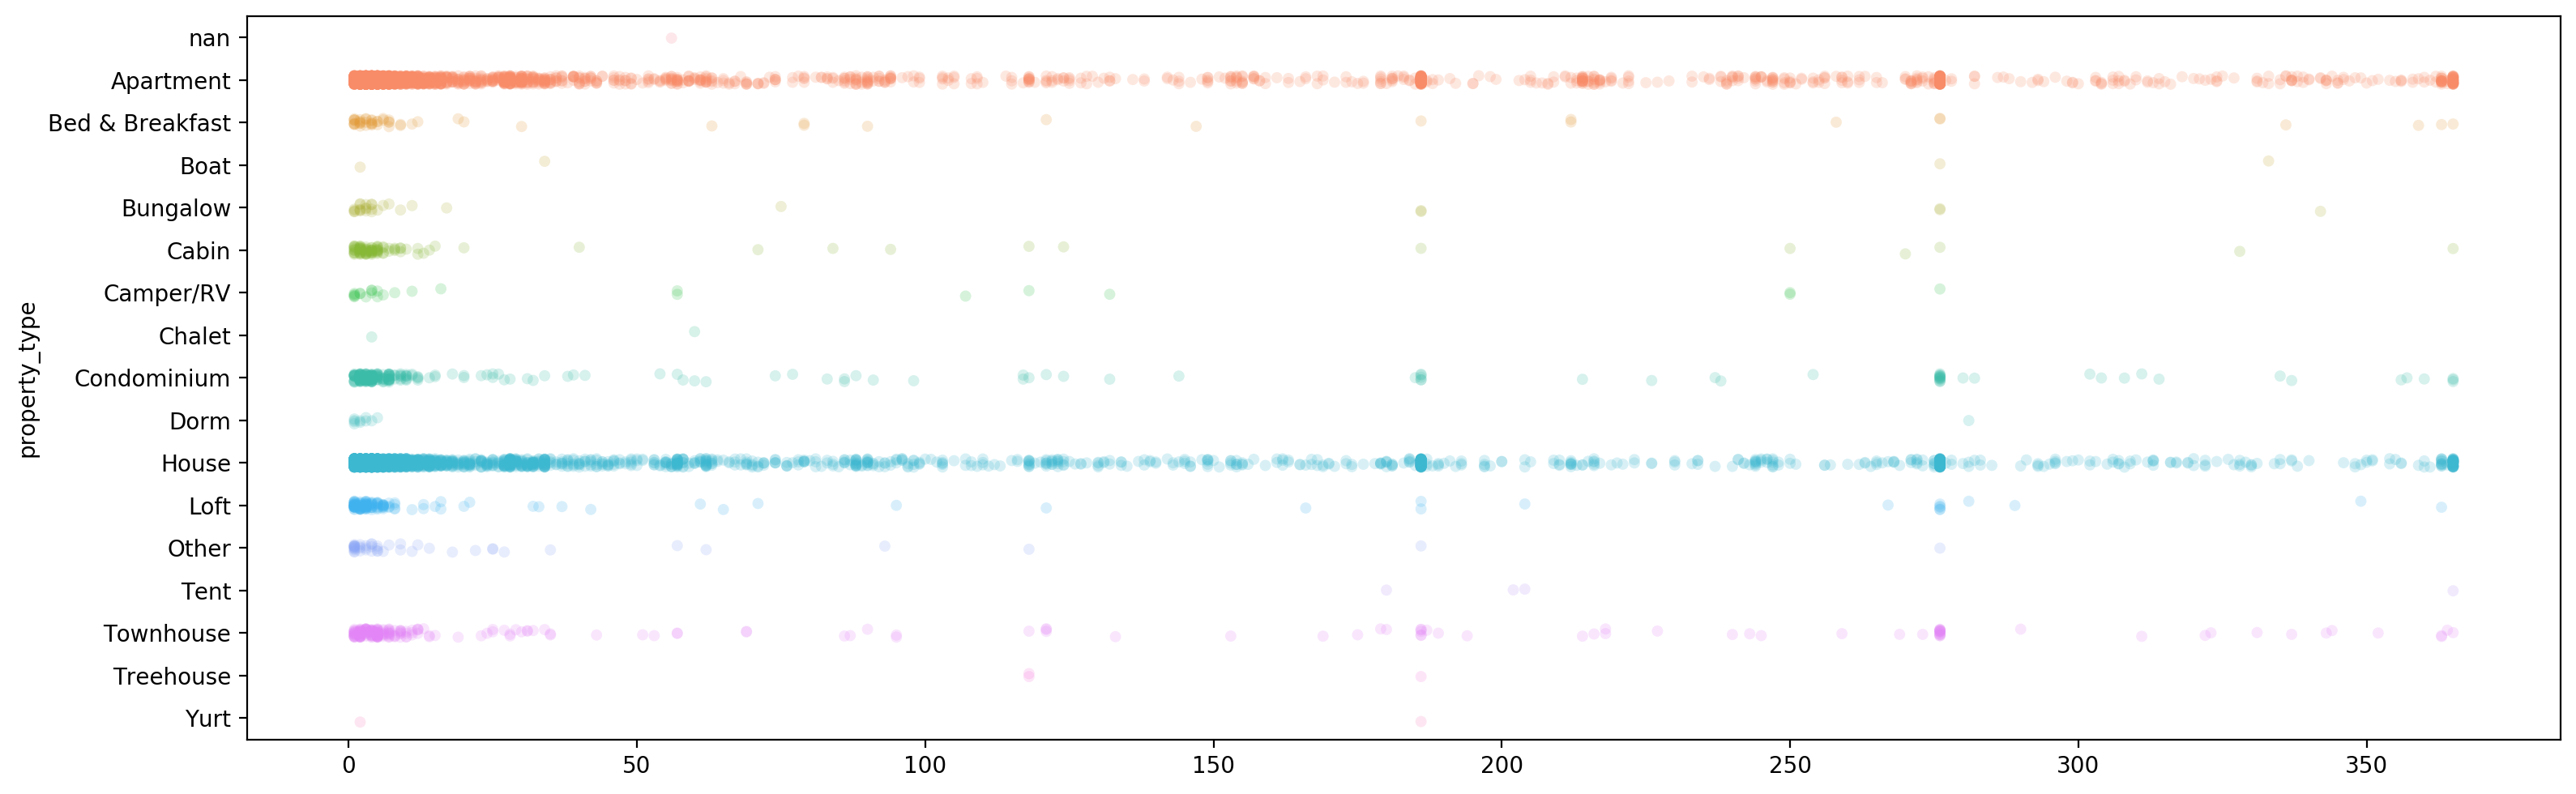

In [70]:
fig,ax = plt.subplots(figsize=(16,5), dpi=200)
sns.stripplot(data=tmp_piv, orient='h', ax=ax, alpha=.2)
fig.set_tight_layout(True);

# What features have inpact on price?

Build a random forest model and gather feature importances